In [166]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
from sklearn import datasets
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import rand_score
from sklearn.neighbors import NearestNeighbors

In [167]:

def initialize_centroids(Data, n_clusters):
    # Randomly select centroids from the data points
    indices = np.random.choice(Data.shape[0], n_clusters, replace=False)
    centroids = Data.iloc[indices]
    return centroids


def update_centroids(Data, labels, n_clusters):
    new_centroids = []
    for i in range(n_clusters):
        cluster_points = Data[labels == i]
        centroid = cluster_points.mean(axis=0)
        new_centroids.append(centroid)
    return pd.DataFrame(new_centroids)


def Euclidean_distance(Data, centroids):
    # Calculate the Euclidean distance between each data point and centroids
    distances = np.sqrt(((Data.values[:, np.newaxis] - centroids.values) ** 2).sum(axis=2))
    # Assign each data point to the closest centroid
    labels = np.argmin(distances, axis=1)
    return labels


def fit_kmean(Data, n_clusters):
    # Initialize centroids
    max_iters = 100
    iteration = 0
    centroids = initialize_centroids(Data, n_clusters)
    old_centroids = pd.DataFrame()
    while iteration < max_iters and not centroids.equals(old_centroids):
        old_centroids = centroids
        labels = Euclidean_distance(Data, centroids)
        centroids = update_centroids(Data, labels, n_clusters)
        iteration += 1

    return labels, centroids





In [168]:
class DBSCAN:

    def __init__(self, Data, minpts, eps):
        self.Data = Data
        self.minpts = minpts
        self.eps = eps
        self.labels = None
        self.n_clusters = 0

    def fit(self):
        self.labels = np.zeros(self.Data.shape[0])
        for i, point in enumerate(self.Data):
            if self.labels[i] == 0:
                neighbors = self.distance(self.Data, point)

                if len(neighbors) < self.minpts:
                    self.labels[i] = -1  # Noise point
                else:
                    self.n_clusters += 1
                    self.expand_cluster(self.Data, point, neighbors, self.n_clusters)

    def distance(self, Data, point):
        neighbors = []
        for i, neighbor in enumerate(Data):
            if np.linalg.norm(neighbor - point) <= self.eps:
                neighbors.append(i)
        return neighbors

    def expand_cluster(self, Data, point, neighbors, cluster):
        cluster_points = [Data[i] for i in neighbors]
        self.labels[neighbors] = cluster

        while len(cluster_points) > 0:
            current_point = cluster_points[0]
            del cluster_points[0]
            current_neighbors = self.distance(Data, current_point)

            if len(current_neighbors) >= self.minpts:
                unvisited = [neighbor for neighbor in current_neighbors if self.labels[neighbor] == 0]
                border = [neighbor for neighbor in current_neighbors if self.labels[neighbor] == -1]

                self.labels[unvisited] = cluster
                self.labels[border] = cluster
                cluster_points += [Data[i] for i in unvisited]



Data set 1

In [199]:
n_samples = 300
Data, y= make_blobs(n_samples=n_samples,  centers=3, random_state=98)


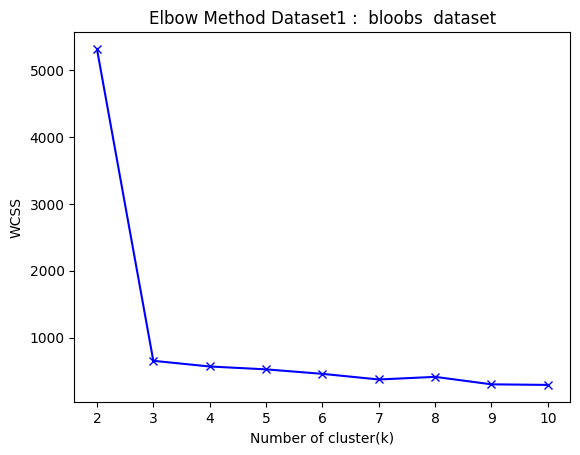

In [200]:
wcss = []
data_k = pd.DataFrame(Data)
k_values = range(2 , 11)
for k in k_values:
  labels ,centroids = fit_kmean(data_k , k)
  wcss.append(np.sum((data_k.values - centroids.values[labels])**2))

plt.plot(k_values , wcss , '-bx')
plt.xlabel("Number of cluster(k)")
plt.ylabel("WCSS")
plt.title("Elbow Method Dataset1 :  bloobs  dataset")
plt.show()

In [171]:
pip install kneed

The best value of eps is: 1.117351661264034


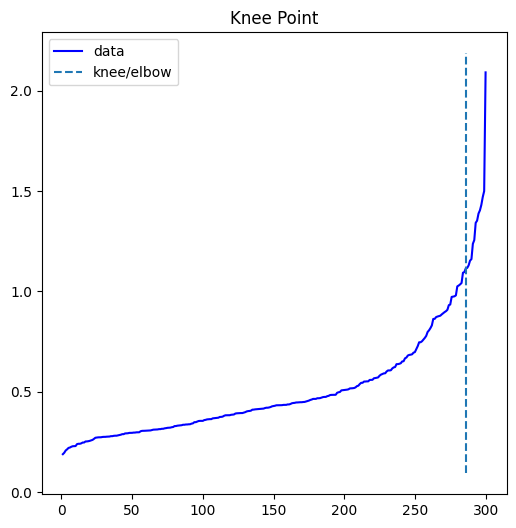

In [172]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Create NearestNeighbors object
neigh1 = NearestNeighbors(n_neighbors=5)
nbrs1 = neigh1.fit(Data)

# Find the distances and indices of the nearest neighbors
distances1, indices1 = nbrs1.kneighbors(Data)

# Sort and plot the distances
distances1 = np.sort(distances1, axis=0)
distances1 = distances1[:, -1]
#plt.plot(distances1)

# Find the knee point
kneedle1 = KneeLocator(x=range(1, len(distances1) + 1), y=distances1, S=1.0,
                      curve="concave", direction="increasing", online=True)
knee_index1 = kneedle1.knee

# Get the eps value at the knee point
eps1 = distances1[knee_index1]
print("The best value of eps is:", eps1)
kneedle1.plot_knee()
plt.show()

In [173]:
dbscan = DBSCAN(Data, minpts=4, eps=eps1)
dbscan.fit()


data=pd.DataFrame(Data)
k_labels, k_centroids=fit_kmean(data,3)


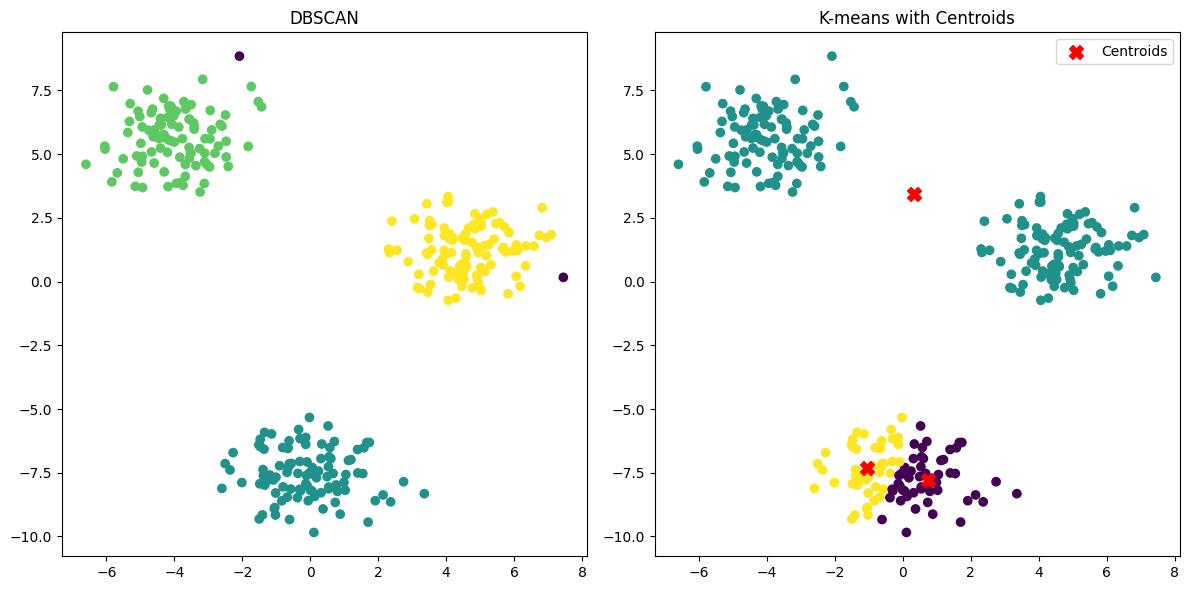

In [174]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot DBSCAN
axs[0].scatter(Data[:, 0], Data[:, 1], c=dbscan.labels, cmap='viridis')
axs[0].set_title('DBSCAN')

# Plot K-means with centroids
axs[1].scatter(Data[:, 0], Data[:, 1], c=k_labels, cmap='viridis')
axs[1].scatter(x=k_centroids.iloc[:, 0], y=k_centroids.iloc[:, 1], marker='X', s=100, c='red', label='Centroids')
axs[1].set_title('K-means with Centroids')
axs[1].legend()

plt.tight_layout()
plt.show()

In [175]:
Fscor_k= f1_score(y, k_labels, average='macro')
FscorDBSCAN= f1_score(y, dbscan.labels, average='macro')
print(f"F_measures for k_mean ={Fscor_k} \nF_measures for BDSCAN= {FscorDBSCAN}")

normal_k=normalized_mutual_info_score(y, k_labels)
normal_DBSCAN=normalized_mutual_info_score(y, dbscan.labels)
print(f"Normalized mutual information for k_mean ={normal_k} \nNormalized mutual information for BDSCAN= {normal_DBSCAN}")

rand_kmean=rand_score(y, k_labels)
rand_DBSCAN=rand_score(y, dbscan.labels)
print(f"Rand statistic for k_mean ={rand_kmean} \nRand statistic for BDSCAN= {rand_DBSCAN}")

F_measures for k_mean =0.43537414965986393 

F_measures for BDSCAN= 0.0

Normalized mutual information for k_mean =0.647661999743698 

Normalized mutual information for BDSCAN= 0.9811854238384864

Rand statistic for k_mean =0.7214938684503902 

Rand statistic for BDSCAN= 0.9955629877369008


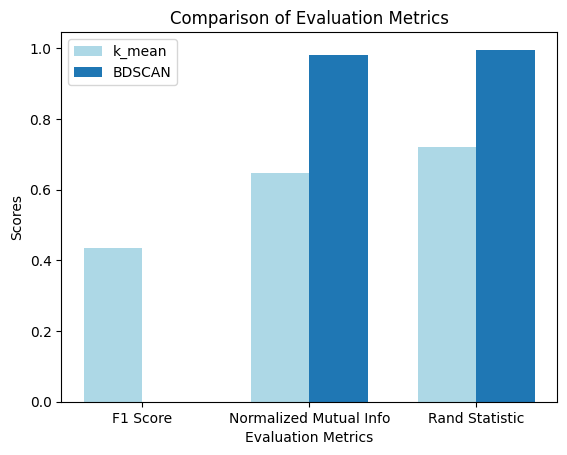

In [176]:
# Define the evaluation metrics
Fscor_k = f1_score(y, k_labels, average='macro')
FscorDBSCAN = f1_score(y, dbscan.labels, average='macro')

normal_k = normalized_mutual_info_score(y, k_labels)
normal_DBSCAN = normalized_mutual_info_score(y, dbscan.labels)

rand_kmean = rand_score(y, k_labels)
rand_DBSCAN = rand_score(y, dbscan.labels)

# Set the metrics and scores
metrics = ['F1 Score', 'Normalized Mutual Info', 'Rand Statistic']
k_mean_scores = [Fscor_k, normal_k, rand_kmean]
BDSCAN_scores = [FscorDBSCAN, normal_DBSCAN, rand_DBSCAN]

# Set the positions of the bars
bar_width = 0.35
index = np.arange(len(metrics))

# Create the grouped bar plot
fig, ax = plt.subplots()
k_mean_bars = ax.bar(index, k_mean_scores, bar_width, label='k_mean',color = "#ADD8E6")
BDSCAN_bars = ax.bar(index + bar_width, BDSCAN_scores, bar_width, label='BDSCAN')

# Customize the plot
ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

Data set 2

In [177]:
n_samples = 300
Data2, y2= datasets.make_blobs(n_samples=n_samples,random_state=98)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
Data2 = np.dot(Data2, transformation)


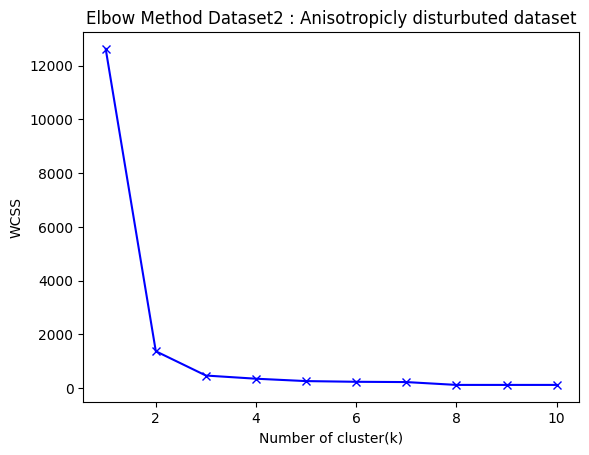

In [178]:
wcss2 = []
data_k2 = pd.DataFrame(Data2)
k_values = range(1,11)
for k in k_values:
  labels ,centroids = fit_kmean(data_k2 , k)
  wcss2.append(np.sum((data_k2.values-centroids.values[labels])**2))

plt.plot(k_values , wcss2 , "-bx")
plt.xlabel("Number of cluster(k)")
plt.ylabel("WCSS")
plt.title("Elbow Method Dataset2 : Anisotropicly disturbuted dataset")
plt.show()

The best value of eps is: 0.35141010386083077


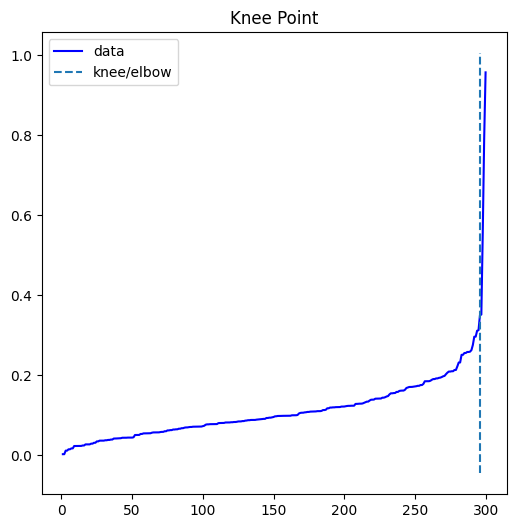

In [179]:
neigh2 = NearestNeighbors(n_neighbors=5)
nbrs2 = neigh2.fit(Data2)

# Find the distances and indices of the nearest neighbors
distances2, indices2 = nbrs2.kneighbors(Data2)

# Sort and plot the distances
distances2 = np.sort(distances2, axis=0)
distances2 = distances2[:, 1]
#plt.plot(distances2)

# Find the knee point
kneedle2 = KneeLocator(x=range(1, len(distances2) + 1), y=distances2, S=1.0,
                      curve="concave", direction="increasing", online=True)
knee_index2 = kneedle2.knee

# Get the eps value at the knee point
epsl2 = distances2[knee_index2]
print("The best value of eps is:", epsl2)
kneedle2.plot_knee()
plt.show()

In [180]:
dbscan = DBSCAN(Data2,minpts=5, eps=epsl2)
dbscan.fit()

data2=pd.DataFrame(Data2)
k_labels2, k_centroids2=fit_kmean(data2,3)

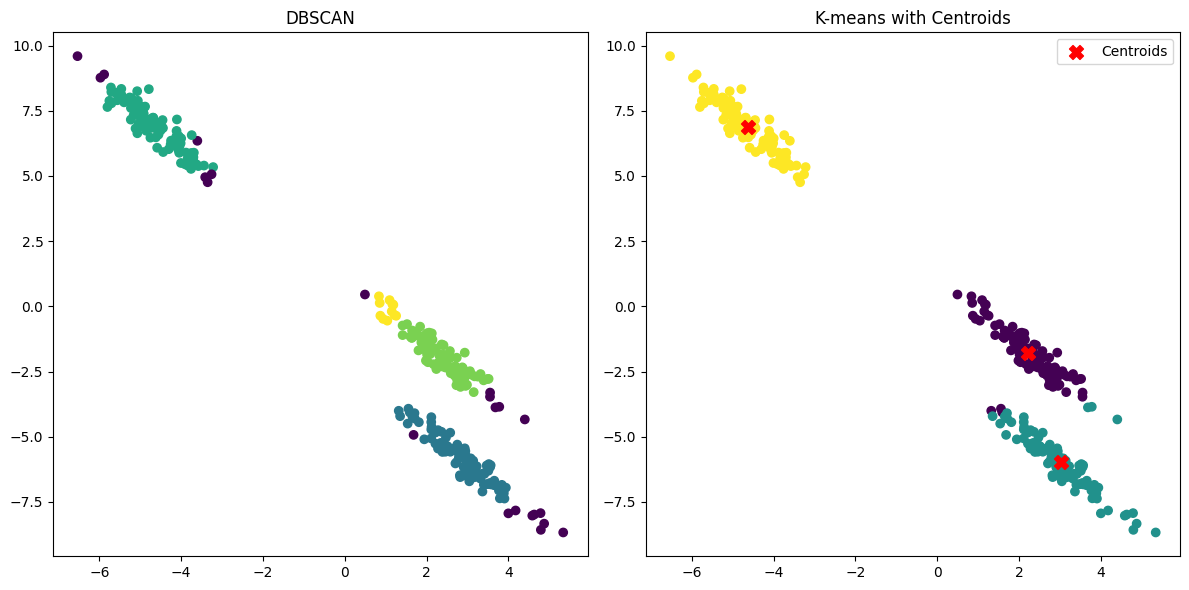

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot DBSCAN
axs[0].scatter(Data2[:, 0], Data2[:, 1], c=dbscan.labels, cmap='viridis')
axs[0].set_title('DBSCAN')

# Plot K-means with centroids
axs[1].scatter(Data2[:, 0], Data2[:, 1], c=k_labels2, cmap='viridis')
axs[1].scatter(x=k_centroids2.iloc[:, 0], y=k_centroids2.iloc[:, 1], marker='X', s=100, c='red', label='Centroids')
axs[1].set_title('K-means with Centroids')
axs[1].legend()

plt.tight_layout()
plt.show()

In [182]:
Fscor_k2= f1_score(y2, k_labels2, average='macro')
FscorDBSCAN2= f1_score(y2, dbscan.labels, average='macro')
print(f"F_measures for k_mean ={Fscor_k2} \nF_measures for BDSCAN= {FscorDBSCAN2}")

normal_k2=normalized_mutual_info_score(y2, k_labels2)
normal_DBSCAN2=normalized_mutual_info_score(y2, dbscan.labels)
print(f"Normalized mutual information for k_mean ={normal_k2} \nNormalized mutual information for BDSCAN= {normal_DBSCAN2}")

rand_kmean2=rand_score(y2, k_labels2)
rand_DBSCAN2=rand_score(y2, dbscan.labels)
print(f"Rand statistic for k_mean ={rand_kmean2} \nRand statistic for BDSCAN= {rand_DBSCAN2}")

F_measures for k_mean =0.3233333333333333 

F_measures for BDSCAN= 0.0

Normalized mutual information for k_mean =0.9182349286946834 

Normalized mutual information for BDSCAN= 0.8179404566977628

Rand statistic for k_mean =0.9740468227424749 

Rand statistic for BDSCAN= 0.930746934225195


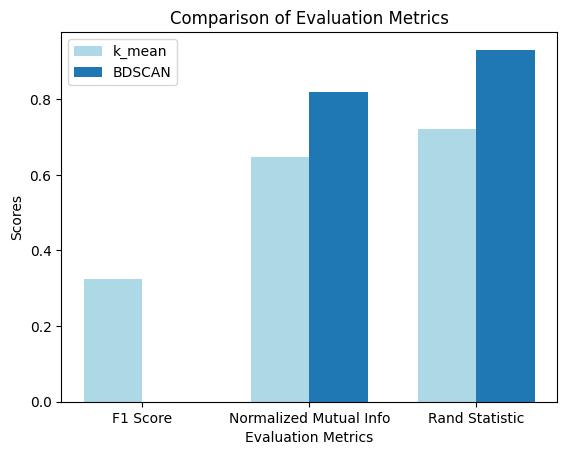

In [183]:
# Define the evaluation metrics
Fscor_k2 = f1_score(y2, k_labels2, average='macro')
FscorDBSCAN2 = f1_score(y2, dbscan.labels, average='macro')

normal_k2 = normalized_mutual_info_score(y2, k_labels)
normal_DBSCAN2 = normalized_mutual_info_score(y2, dbscan.labels)

rand_kmean2 = rand_score(y2, k_labels)
rand_DBSCAN2 = rand_score(y2, dbscan.labels)

# Set the metrics and scores
metrics = ['F1 Score', 'Normalized Mutual Info', 'Rand Statistic']
k_mean_scores2 = [Fscor_k2, normal_k2, rand_kmean2]
BDSCAN_scores2 = [FscorDBSCAN2, normal_DBSCAN2, rand_DBSCAN2]

# Set the positions of the bars
bar_width = 0.35
index = np.arange(len(metrics))

# Create the grouped bar plot
fig, ax = plt.subplots()
k_mean_bars2 = ax.bar(index, k_mean_scores2, bar_width, label='k_mean',color = "#ADD8E6")
BDSCAN_bars2 = ax.bar(index + bar_width, BDSCAN_scores2, bar_width, label='BDSCAN')

# Customize the plot
ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

Data set 3

In [184]:
Data3, y3 = datasets.make_moons(n_samples=n_samples, noise=0.1,random_state=98)


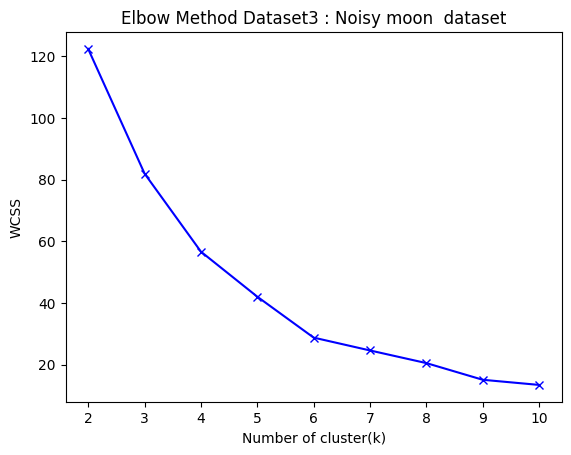

In [185]:
wcss3 = []
data_k3 = pd.DataFrame(Data3)
k_values = range(2,11)
for k in k_values:
  labels ,centroids = fit_kmean(data_k3 , k)
  wcss3.append(np.sum((data_k3.values - centroids.values[labels])**2))

plt.plot(k_values , wcss3 , '-bx')
plt.xlabel("Number of cluster(k)")
plt.ylabel("WCSS")
plt.title("Elbow Method Dataset3 : Noisy moon  dataset")
plt.show()

The best value of eps is: 0.1712860949046791


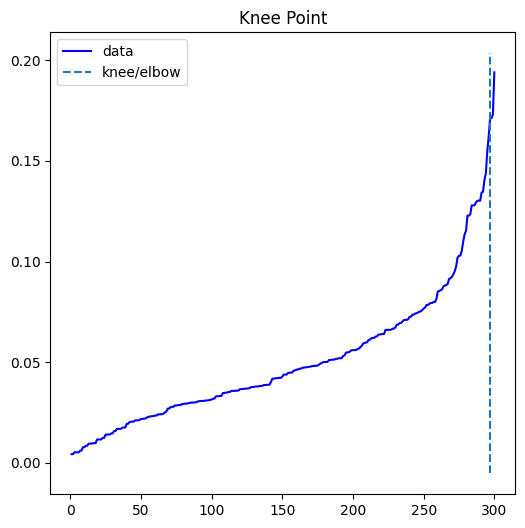

In [186]:
neigh3 = NearestNeighbors(n_neighbors=5)
nbrs3 = neigh3.fit(Data3)

# Find the distances and indices of the nearest neighbors
distances3, indices3 = nbrs3.kneighbors(Data3)

# Sort and plot the distances
distances3 = np.sort(distances3, axis=0)
distances3 = distances3[:, 1]
#plt.plot(distances3)

# Find the knee point
kneedle3 = KneeLocator(x=range(1, len(distances3) + 1), y=distances3, S=1.0,
                      curve="concave", direction="increasing", online=True)
knee_index3 = kneedle3.knee

# Get the eps value at the knee point
epsl3 = distances3[knee_index3]
print("The best value of eps is:", epsl3)
kneedle3.plot_knee()
plt.show()

In [187]:
dbscan3 = DBSCAN(Data3,minpts=4, eps=epsl3)
dbscan3.fit()

data3=pd.DataFrame(Data3)
k_labels3, k_centroids3 =fit_kmean(data3,3)

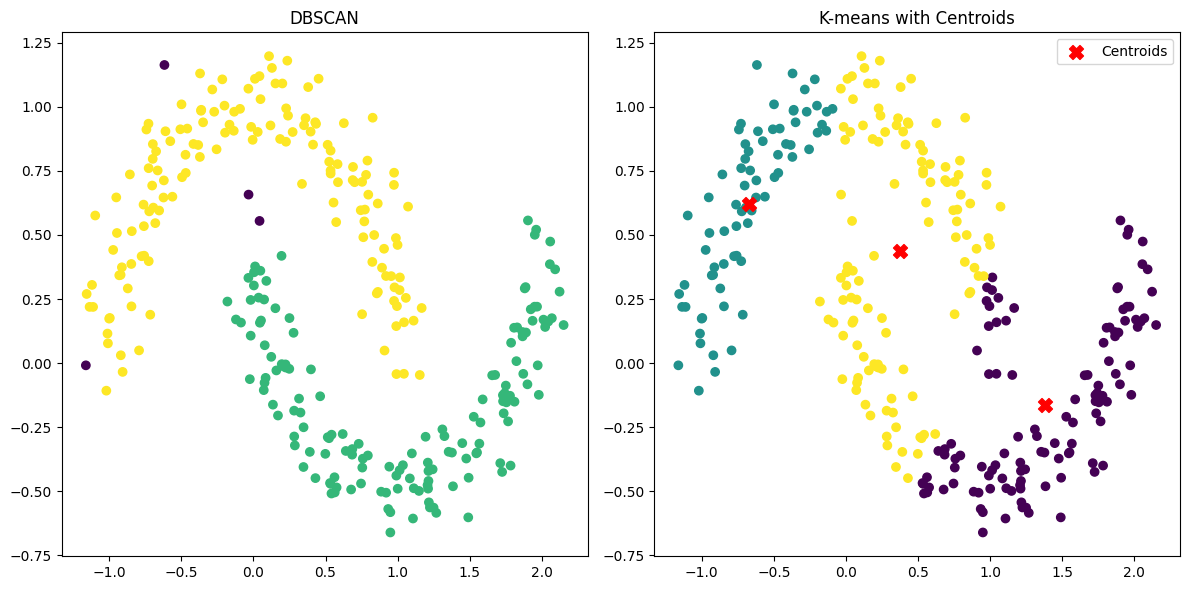

In [188]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot DBSCAN
axs[0].scatter(Data3[:, 0], Data3[:, 1], c=dbscan3.labels, cmap='viridis')
axs[0].set_title('DBSCAN')

# Plot K-means with centroids
axs[1].scatter(Data3[:, 0], Data3[:, 1], c=k_labels3, cmap='viridis')
axs[1].scatter(x=k_centroids3.iloc[:, 0], y=k_centroids3.iloc[:, 1], marker='X', s=100, c='red', label='Centroids')
axs[1].set_title('K-means with Centroids')
axs[1].legend()

plt.tight_layout()
plt.show()

In [189]:
Fscor_k3= f1_score(y3, k_labels3, average='macro')
FscorDBSCAN3= f1_score(y3, dbscan3.labels, average='macro')
print(f"F_measures for k_mean ={Fscor_k3} \nF_measures for BDSCAN= {FscorDBSCAN3}")

normal_k3=normalized_mutual_info_score(y3, k_labels3)
normal_DBSCAN3=normalized_mutual_info_score(y3, dbscan3.labels)
print(f"Normalized mutual information for k_mean ={normal_k3} \nNormalized mutual information for BDSCAN= {normal_DBSCAN3}")

rand_kmean3=rand_score(y3, k_labels3)
rand_DBSCAN3=rand_score(y3, dbscan3.labels)
print(f"Rand statistic for k_mean ={rand_kmean3} \nRand statistic for BDSCAN= {rand_DBSCAN3}")

F_measures for k_mean =0.035487959442332066 

F_measures for BDSCAN= 0.2483221476510067

Normalized mutual information for k_mean =0.3261356329545521 

Normalized mutual information for BDSCAN= 0.9447098794015842

Rand statistic for k_mean =0.6385507246376811 

Rand statistic for BDSCAN= 0.9867112597547381


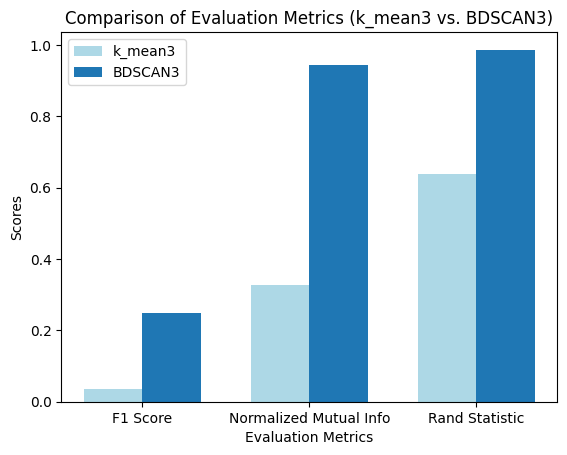

In [190]:
# Define the evaluation metrics
Fscor_k3 = f1_score(y3, k_labels3, average='macro')
FscorDBSCAN3 = f1_score(y3, dbscan3.labels, average='macro')
normal_k3 = normalized_mutual_info_score(y3, k_labels3)
normal_DBSCAN3 = normalized_mutual_info_score(y3, dbscan3.labels)
rand_kmean3 = rand_score(y3, k_labels3)
rand_DBSCAN3 = rand_score(y3, dbscan3.labels)

# Set the metrics and scores
metrics = ['F1 Score', 'Normalized Mutual Info', 'Rand Statistic']
k_mean_scores3 = [Fscor_k3, normal_k3, rand_kmean3]
BDSCAN_scores3 = [FscorDBSCAN3, normal_DBSCAN3, rand_DBSCAN3]

# Set the positions of the bars
bar_width = 0.35
index = np.arange(len(metrics))

# Create the bar plot
fig, ax = plt.subplots()
k_mean_bars3 = ax.bar(index, k_mean_scores3, bar_width, label='k_mean3', color="#ADD8E6")
BDSCAN_bars3 = ax.bar(index + bar_width, BDSCAN_scores3, bar_width, label='BDSCAN3')

# Customize the plot
ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics (k_mean3 vs. BDSCAN3)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

Data set 4

In [191]:
Data4,y4 = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05,random_state=98)

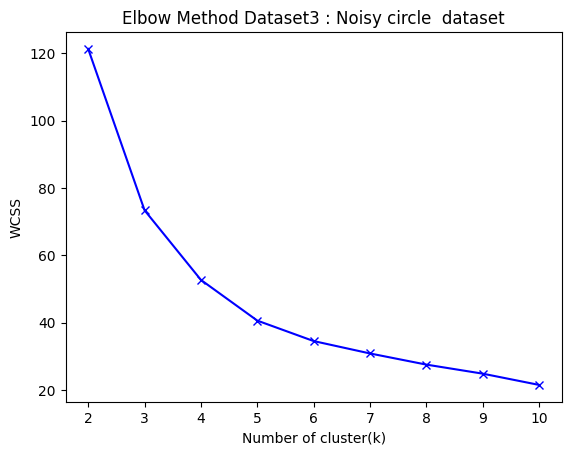

In [192]:
wcss4 = []
data_k4 = pd.DataFrame(Data4)
k_values = range(2,11)
for k in k_values:
  labels ,centroids = fit_kmean(data_k4 , k)
  wcss4.append(np.sum((data_k4.values - centroids.values[labels])**2))

plt.plot(k_values , wcss4 , '-bx')
plt.xlabel("Number of cluster(k)")
plt.ylabel("WCSS")
plt.title("Elbow Method Dataset3 : Noisy circle  dataset")
plt.show()

The best value of eps is: 0.09728612082404003


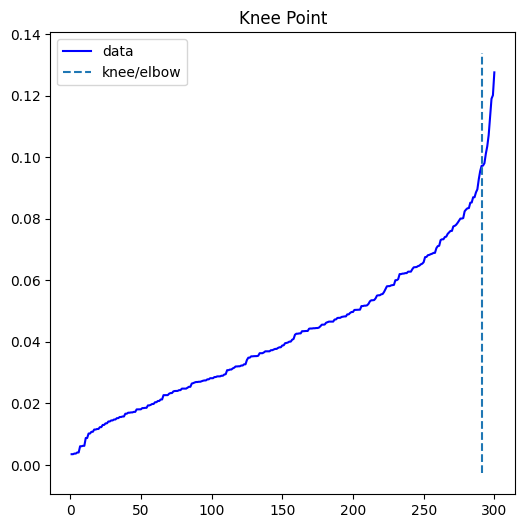

In [193]:
neigh4 = NearestNeighbors(n_neighbors=5)
nbrs4 = neigh4.fit(Data4)

# Find the distances and indices of the nearest neighbors
distances4, indices4 = nbrs4.kneighbors(Data4)

# Sort and plot the distances
distances4 = np.sort(distances4, axis=0)
distances4 = distances4[:, 1]
#plt.plot(distances4)

# Find the knee point
kneedle4 = KneeLocator(x=range(1, len(distances4) + 1), y=distances4, S=1.0,
                      curve="concave", direction="increasing", online=True)
knee_index4 = kneedle4.knee

# Get the eps value at the knee point
epsl4 = distances4[knee_index4]
print("The best value of eps is:", epsl4)
kneedle4.plot_knee()
plt.show()

In [194]:
dbscan4 = DBSCAN(Data4,minpts=4, eps=epsl4)
dbscan4.fit()

data4=pd.DataFrame(Data4)
k_labels4, k_centroids4 =fit_kmean(data4,3)

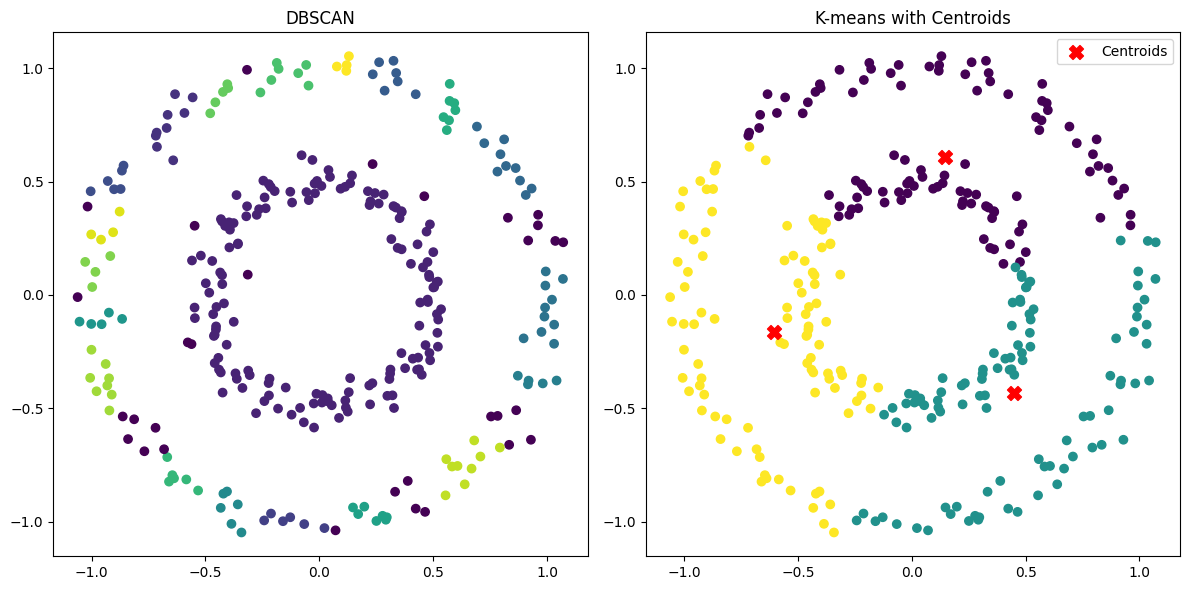

In [195]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot DBSCAN
axs[0].scatter(Data4[:, 0], Data4[:, 1], c=dbscan4.labels, cmap='viridis')
axs[0].set_title('DBSCAN')

# Plot K-means with centroids
axs[1].scatter(Data4[:, 0], Data4[:, 1], c=k_labels4, cmap='viridis')
axs[1].scatter(x=k_centroids4.iloc[:, 0], y=k_centroids4.iloc[:, 1], marker='X', s=100, c='red', label='Centroids')
axs[1].set_title('K-means with Centroids')
axs[1].legend()

plt.tight_layout()
plt.show()

In [196]:
Fscor_k4= f1_score(y4, k_labels4, average='macro')
FscorDBSCAN4= f1_score(y4, dbscan4.labels, average='macro')
print(f"F_measures for k_mean ={Fscor_k4} \nF_measures for BDSCAN= {FscorDBSCAN4}")

normal_k4=normalized_mutual_info_score(y4, k_labels4)
normal_DBSCAN4=normalized_mutual_info_score(y4, dbscan4.labels)
print(f"Normalized mutual information for k_mean ={normal_k4} \nNormalized mutual information for BDSCAN= {normal_DBSCAN4}")

rand_kmean4=rand_score(y4, k_labels4)
rand_DBSCAN4=rand_score(y4, dbscan4.labels)
print(f"Rand statistic for k_mean ={rand_kmean4} \nRand statistic for BDSCAN= {rand_DBSCAN4}")

F_measures for k_mean =0.27356613756613757 

F_measures for BDSCAN= 0.04452690166975881

Normalized mutual information for k_mean =0.00014739099380133068 

Normalized mutual information for BDSCAN= 0.45001689079547225

Rand statistic for k_mean =0.4984169453734671 

Rand statistic for BDSCAN= 0.7434336677814939


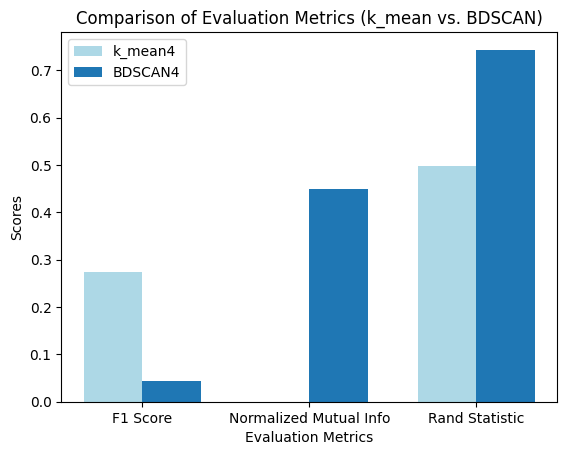

In [197]:
# Define the evaluation metrics
Fscor_k4 = f1_score(y4, k_labels4, average='macro')
FscorDBSCAN4 = f1_score(y4, dbscan4.labels, average='macro')
normal_k4 = normalized_mutual_info_score(y4, k_labels4)
normal_DBSCAN4 = normalized_mutual_info_score(y4, dbscan4.labels)
rand_kmean4 = rand_score(y4, k_labels4)
rand_DBSCAN4 = rand_score(y4, dbscan4.labels)

# Set the metrics and scores
metrics = ['F1 Score', 'Normalized Mutual Info', 'Rand Statistic']
k_mean_scores4 = [Fscor_k4, normal_k4, rand_kmean4]
BDSCAN_scores4 = [FscorDBSCAN4, normal_DBSCAN4, rand_DBSCAN4]

# Set the positions of the bars
bar_width = 0.35
index = np.arange(len(metrics))

# Set the colors for the bars

# Create the bar plot
fig, ax = plt.subplots()
k_mean_bars4 = ax.bar(index, k_mean_scores4, bar_width, label='k_mean4', color="#ADD8E6")
BDSCAN_bars4 = ax.bar(index + bar_width, BDSCAN_scores4, bar_width, label='BDSCAN4')

# Customize the plot
ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics (k_mean vs. BDSCAN)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

In [198]:
data = {
    'DataSets': ['Dataset 1', 'Dataset 1', 'Dataset 2', 'Dataset 2', 'Dataset 3', 'Dataset 3', 'Dataset 4', 'Dataset 4'],
    'Algorithm': ['K-means', 'DBSCAN', 'K-means', 'DBSCAN', 'K-means', 'DBSCAN', 'K-means', 'DBSCAN'],
    'F1 score': [Fscor_k, FscorDBSCAN, Fscor_k2, FscorDBSCAN2,Fscor_k3, FscorDBSCAN3,Fscor_k4, FscorDBSCAN4],
    'Rand score': [rand_kmean, rand_DBSCAN, rand_kmean2, rand_DBSCAN2,rand_kmean3, rand_DBSCAN3,rand_kmean4, rand_DBSCAN4],
    'NMI': [normal_k, normal_DBSCAN, normal_k2, normal_DBSCAN2,normal_k3, normal_DBSCAN3,normal_k4, normal_DBSCAN4]
}

# Create the DataFrame to see the dataset with measures of the algorithms
df = pd.DataFrame(data)
df

,DataSets,Algorithm,F1 score,Rand score,NMI
0,Dataset 1,K-means,0.435374,0.721494,0.647662
1,Dataset 1,DBSCAN,0.000000,0.995563,0.981185
2,Dataset 2,K-means,0.323333,0.721494,0.647662
3,Dataset 2,DBSCAN,0.000000,0.930747,0.817940
4,Dataset 3,K-means,0.035488,0.638551,0.326136
5,Dataset 3,DBSCAN,0.248322,0.986711,0.944710
6,Dataset 4,K-means,0.273566,0.498417,0.000147
7,Dataset 4,DBSCAN,0.044527,0.743434,0.450017
